In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(19680801)

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [2]:
# Utilities for the movie
def update_movie(frame):
    # Clear the previous plot
    ax.clear()
    
    # Plot the current matrix from the sequence
    plt.imshow(System_frames[frame])
    
    plt.title(f'Frame {frame}')

In [3]:
# Simulation parameters
runsNumber = 100
totalMCS = 200 #Total number of Monte Carlo steps per single run
Lx = 40 # Number of columns, length
Ly = 20 # Number of rows, height
N = Lx * Ly // 2 # Number of particles
size = Lx * Ly

# Check utilities
print_stuff = 0 #0 do not print; 1 print basics; 2 print details; for unit tests

SystemCheckboard = np.zeros((Ly, Lx), dtype=int)  # Ly vectors with Lx (zero) components 
SystemCheckboard[::2, ::2] = 1  # Set even rows and even columns to 1
SystemCheckboard[1::2, 1::2] = 1  # Set odd rows and odd columns to 1

# Memory allocation                   
DensityParticlesTot = np.zeros(totalMCS) 
CorrTot = np.zeros(totalMCS) 
CurrentAlongTot = np.zeros(totalMCS)  # totalMCS vectors with Ly (zero) components 
CurrentTransverseTot = np.zeros(totalMCS)  # totalMCS vectors with Ly (zero) components
OccupationGridTot = np.zeros((Ly, Lx))

In [4]:
# Beginning of the simulation
for iwalk in range(runsNumber):
    
    # Clearing arrays from the last run
    System = np.zeros((Ly, Lx), dtype=int)  # Ly vectors with Lx (zero) components 

    Corr = np.zeros(totalMCS)
    DensityParticles = np.zeros(totalMCS) 
    OccupationGrid = np.zeros((Ly, Lx))
    CurrentAlong = np.zeros(totalMCS) 
    CurrentTransverse = np.zeros(totalMCS)
        
    # Filling the lattice with particles alternatively (chess fashion)    
    System[::2, ::2] = 1  # Set even rows and even columns to 1
    System[1::2, 1::2] = 1  # Set odd rows and odd columns to 1

    # Mapping System at t=0
    SystemSnapshot = np.zeros((Ly, Lx), dtype=int)    
    SystemSnapshot = System.copy()

    System_frames = np.zeros((totalMCS+1, Ly, Lx), dtype=int)
    System_frames[0] = SystemSnapshot

    # Beginning of a single run
    for istep in range(totalMCS):
        CurrentAlong_temp = np.zeros((Lx)) 
        CurrentTransverse_temp = np.zeros((Ly))

        for moveAttempt in range(N):
            while True:
                dice = random.randint(0, Lx * Ly - 1)  # Picks the random lattice site in the array
                X = dice // Lx
                Y = dice - X * Lx
                
                """ 
                The lattice is labelled from the left top to the right 
                 as Z= 0, 1, 2    or    [X,Y]= (0,0), (0,1), (0,2) 
                       3, 4, 5                 (1,0), (1,1), (1,2)
                """


                if System[X][Y] == 1: # The lattice is occupied
                    
                    # Simple implementation of Periodic boundary conditions
                    xPrev = Ly - 1 if X == 0 else X - 1
                    xNext = 0 if X == Ly - 1 else X + 1
                    yPrev = Lx - 1 if Y == 0 else Y - 1
                    yNext = 0 if Y == Lx - 1 else Y + 1
                    
                    # Simulating exchange dynamics  
                    # - Possibility 1: p=1/2 of jumping foward, p=1/4 of jumping up or down, in total p=1/2                  
                    dice_jump = random.randint(0, 1) 
                    if dice_jump == 0:
                        JumpAlong = random.randint(0, 1)
                        JumpTransverse = 2 # No jump up or down
                    else:
                        JumpAlong = 2 # No jump forward
                        JumpTransverse = random.randint(0, 1)
                                        
                    # - Possibility 2: p=1/2 of jumping foward, jumping up or down, in total p=1                
                    # JumpAlong = random.randint(0, 2)
       
                    
                    if JumpAlong == 0 and System[X][yNext] == 0:  # hop forward
                        temp = System[X][Y]
                        System[X][Y] = System[X][yNext]
                        System[X][yNext] = temp
                        CurrentAlong_temp[Y] += 1
                        if print_stuff == 2: print("Particle at (%s, %s) hops foward" % (X, Y))

                    # if JumpAlong == 1 and System[X][yPrev] == 0:  # hop backward                    
                    #     temp = System[X][Y]
                    #     System[X][Y] = System[X][yPrev]
                    #     System[X][yPrev] = temp
                    #     CurrentAlong_temp[Y] -= 1

                    if JumpTransverse == 0 and System[xPrev][Y] == 0: # hop up
                        temp = System[X][Y]
                        System[X][Y] = System[xPrev][Y]
                        System[xPrev][Y] = temp
                        CurrentTransverse_temp[X] += 1
                        if print_stuff == 2: print("Particle at (%s, %s) hops up" % (X, Y))


                    if JumpTransverse == 1 and System[xNext][Y] == 0:  # hop down
                        temp = System[X][Y]
                        System[X][Y] = System[xNext][Y]
                        System[xNext][Y] = temp
                        CurrentTransverse_temp[X] -= 1
                        if print_stuff == 2: print("Particle at (%s, %s) hops down" % (X, Y))

                    break  # Exit the loop
                    
        # Computes currents
        CurrentAlong[istep] = CurrentAlong_temp.sum(axis=0)/N # Sum of the current in each lattice in Ly
        CurrentTransverse[istep] = CurrentTransverse_temp.sum(axis=0)/ N # Sum of the current in each lattice in Lx
                    
        # Computes the total number of particles
        DensityParticles[istep] = np.sum(System) / size
        
        if DensityParticles[istep] != 0.5:
            print("Error: The density of particles does not conserve")
        
        # Computes correlation function       
        Sum = 0
        for i in range(Ly):
            for j in range(Lx):
                Sum += System[i][j] * SystemSnapshot[i][j]
                
        Corr[istep] = (Sum / size) - (DensityParticles[istep])**2 # 0.25 is the density of particles^2
        
        if print_stuff == 1 or print_stuff == 2:
            if (SystemSnapshot != SystemCheckboard).all():
                print("Error: System at t=0, not in checkboard mode")
        
        # To compute occupation probability
        OccupationGrid += System
        
        # Frames for the movie
        System_frames[istep+1] = System


    # Computing parameters after a single run
    OccupationGrid /= totalMCS
    
    OccupationGridTot += OccupationGrid
    for dt in range(totalMCS):
        CorrTot[dt] += Corr[dt]
        DensityParticlesTot[dt] += DensityParticles[dt] 
        CurrentAlongTot[dt] += CurrentAlong[dt]
        CurrentTransverseTot[dt] += CurrentTransverse[dt]
    
    if print_stuff == 1 or print_stuff == 2: print("Runs done:", iwalk+1)

    
# Simulation results output
for dt in range(totalMCS):
    CorrTot[dt] /= runsNumber
    DensityParticlesTot[dt] /= (runsNumber)
    CurrentAlongTot[dt] /= (runsNumber)
    CurrentTransverseTot[dt] /= (runsNumber)

# Occupation probability of the X axis
OccupationGridTot /= runsNumber
HorizontalOccupProb = OccupationGridTot.sum(axis=0)/Ly

    
print('Finished!')  

Finished!


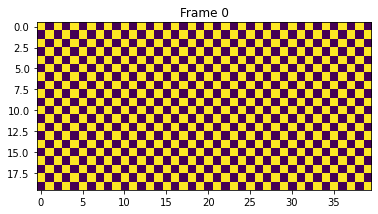

In [5]:
#Movie for the last run. Recommended when MCS is not higher than 200
fig, ax = plt.subplots()

ani = FuncAnimation(fig, update_movie, frames=len(System_frames), repeat=False)

HTML(ani.to_jshtml())

1) total number of particles stays constant at all times


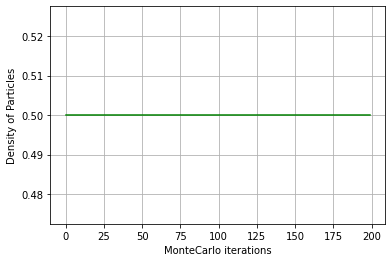

In [6]:
# Testing Area

print('1) total number of particles stays constant at all times')

x_axis=np.array(range(totalMCS))
plt.plot(x_axis, DensityParticlesTot, color='green')
plt.xlabel('MonteCarlo iterations')
plt.ylabel('Density of Particles')
plt.grid(True) 

plt.show()

In [7]:
# print('2) Autocorrelation function ~ 1/t')

# x_axis=np.array(range(1,totalMCS+1))
# f=1/x_axis
# plt.plot(x_axis, f, color='black')
# plt.plot(x_axis, CorrTot, '.', color='coral')
# plt.xlabel('MonteCarlo iterations')
# plt.ylabel('Autocorrelation Function')
# plt.xscale('log')
# plt.yscale('log')
# plt.grid(True) 

# plt.show()

3) parallel current ~ rewrite & Perpendicular Current=0


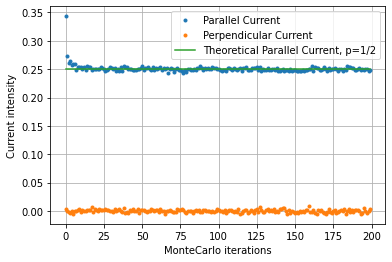

In [8]:
print('3) parallel current ~ rewrite & Perpendicular Current=0')

# Ruslan: Situation where each direction is chosen with equal probability, p=1/2 and you should get 0.125 current value for rho=1/2. 
#Another choice is to have 1/4 for jump up, 1/4 for jump down and 1/2 for jump forward probabilities, and then your p=1 and the current will be 0.25. 
#Both of these choices should only differ in the timescale, i.e., one case would transform to another by simple t'=2t rescaling. So you can try any of them

#The steady current of particle J, through a bond i, i+1 is given by the rate r multiplied by the probability that there is a particle at site i, and site i+1 is vacant
r=1
p=1/2
prob_vac=1/2
f2=np.array([r*p*prob_vac]*totalMCS)
f3=np.array([0.25]*totalMCS)

plt.plot(x_axis, CurrentAlongTot, '.', label='Parallel Current')
plt.plot(x_axis, CurrentTransverseTot, '.', label='Perpendicular Current')
#plt.plot(x_axis,f2, label='Theoretical Parallel Current, p=1')
plt.plot(x_axis,f3, label='Theoretical Parallel Current, p=1/2')

plt.xlabel('MonteCarlo iterations')
plt.ylabel('Current intensity')
plt.legend()
plt.grid(True)

plt.show()

4) Occupation probability


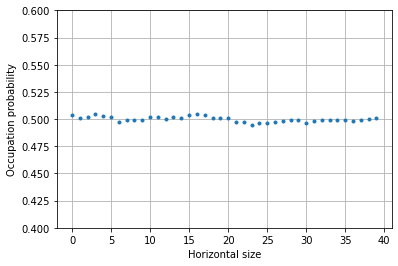

In [9]:
print('4) Occupation probability')

x_axis=np.array(range(Lx))

plt.plot(x_axis, HorizontalOccupProb, '.')

plt.xlabel('Horizontal size')
plt.ylabel('Occupation probability')
plt.ylim([0.4,0.6])
plt.grid(True)

plt.show()